# The final model
 

## Model v5.0 - Final model with all tuned base models

In [1]:
import pandas as pd
from data import load_data_selected_features

train_data, additional_train_data, test_data = load_data_selected_features()

In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150996 entries, p01_0 to p12_25298
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 585.2+ MB


In [3]:
additional_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168588 entries, p01_test_12 to p24_test_94938
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 657.4+ MB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3644 entries, p01_8459 to p24_260
Columns: 506 entries, p_num to activity-0:00
dtypes: float64(432), object(74)
memory usage: 14.2+ MB


# Prepare the data

In [5]:
from pipelines_selected_features import pipeline

all_train_data = pd.concat([train_data, additional_train_data], axis=0)
all_train_data_transformed = pipeline.fit_transform(all_train_data)

train_data_transformed = all_train_data_transformed[:len(train_data)]
additional_train_data_transformed = all_train_data_transformed[len(train_data):]

X_train = train_data_transformed.drop(columns=['bg+1:00'])
y_train = train_data_transformed['bg+1:00']

X_additional_train = additional_train_data_transformed.drop(columns=['bg+1:00'])
y_additional_train = additional_train_data_transformed['bg+1:00']

## Predict for validation data and check results

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor


def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def create_dnn_model(input_dimension: int):
    dnn = Sequential([
        Input(shape=(input_dimension,)),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(1, activation='linear')
    ])

    dnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=[rmse]
    )

    return dnn


def model_with_pretrained_weights():
    dnn = create_dnn_model(X_train.shape[1])
    dnn.load_weights('v5.0.weights.h5')  # Load the pre-trained weights

    # Freeze all layers except the last one (optional)
    for layer in dnn.layers:
        layer.trainable = False
    # Unfreeze the output layer if you want to fine-tune it
    # dnn.layers[-1].trainable = True

    dnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=[rmse]
    )
    return dnn


In [7]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LassoLarsIC, Ridge
from tensorflow.keras.callbacks import EarlyStopping

hgb_estimator = HistGradientBoostingRegressor(
    l2_regularization=0.0001,
    learning_rate=0.1,
    max_depth=11,
    max_iter=1500,
    min_samples_leaf=10,
    n_iter_no_change=22,
    random_state=42,
)

lasso_lars_ic_base_model = LassoLarsIC(
    criterion='aic',
    eps=0.03922948513965659,
    max_iter=1944,
    noise_variance=5.4116687755186035e-05,
    positive=False,
)

knn_base_estimator = KNeighborsRegressor(
    leaf_size=30,
    metric='minkowski',
    n_neighbors=7,
    p=2,
    weights='uniform'
)

xgb_base_estimator = XGBRegressor(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.05,
    min_child_weight=6,
    colsample_bytree=0.8,
    subsample=0.8,
    gamma=1,
    reg_lambda=10.0,
    reg_alpha=1.0,
    objective='reg:squarederror',
    random_state=42,
)

# pretrain the DNN and use the weights in the stacking model
pretrained_dnn = create_dnn_model(X_train.shape[1])
pretrained_dnn.fit(
    pd.concat([X_train, X_additional_train], axis=0),
    pd.concat([y_train, y_additional_train], axis=0),
    epochs=100,
    verbose=2,
    validation_data=(X_additional_train, y_additional_train),
    validation_split=0.2,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]
)
pretrained_dnn.save_weights('v5.0.weights.h5')

keras_regressor = KerasRegressor(
    model=model_with_pretrained_weights,
    epochs=1,
    verbose=2
)

estimators = [
    ('hgb', hgb_estimator),
    ('lasso_lars_ic', lasso_lars_ic_base_model),
    ('knn', knn_base_estimator),
    ('xgb', xgb_base_estimator),
    ('dnn', keras_regressor)
]

model = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=0.1), n_jobs=1, verbose=2)

Epoch 1/100
9987/9987 - 8s - 839us/step - loss: 7.9745 - rmse: 2.6367 - val_loss: 4.6874 - val_rmse: 1.9181
Epoch 2/100
9987/9987 - 7s - 729us/step - loss: 5.2780 - rmse: 2.2665 - val_loss: 4.3635 - val_rmse: 1.8657
Epoch 3/100
9987/9987 - 7s - 715us/step - loss: 4.9728 - rmse: 2.1989 - val_loss: 4.2872 - val_rmse: 1.8458
Epoch 4/100
9987/9987 - 7s - 734us/step - loss: 4.7759 - rmse: 2.1542 - val_loss: 4.2829 - val_rmse: 1.8448
Epoch 5/100
9987/9987 - 7s - 698us/step - loss: 4.6500 - rmse: 2.1261 - val_loss: 4.2187 - val_rmse: 1.8353
Epoch 6/100
9987/9987 - 7s - 725us/step - loss: 4.5740 - rmse: 2.1087 - val_loss: 4.1498 - val_rmse: 1.8184
Epoch 7/100
9987/9987 - 8s - 836us/step - loss: 4.5093 - rmse: 2.0933 - val_loss: 4.1194 - val_rmse: 1.8192
Epoch 8/100
9987/9987 - 7s - 743us/step - loss: 4.4780 - rmse: 2.0865 - val_loss: 4.1629 - val_rmse: 1.8176
Epoch 9/100
9987/9987 - 7s - 722us/step - loss: 4.4319 - rmse: 2.0757 - val_loss: 4.0668 - val_rmse: 1.8008
Epoch 10/100
9987/9987 - 7s 

14:22:19 - Start training
14:22:19 - Calculate performance for hgb
14:22:19 - Selected splitter: ShuffleSplit(n_splits=5, random_state=42, test_size=0.2, train_size=None)
14:22:19 - Split 1 - Model: hgb
14:22:19 - Fitting the model
14:23:05 - Predicting
14:23:05 - Calculating scores
14:23:05 - R^2: 0.6802980598686639, RMSE: 1.853234323545247, MAE: 1.3781103796392653, MSE: 3.4344774579662096
14:23:05 - Split 2 - Model: hgb
14:23:05 - Fitting the model
14:23:51 - Predicting
14:23:51 - Calculating scores
14:23:51 - R^2: 0.6790084797635141, RMSE: 1.8599546082369873, MAE: 1.389380261014941, MSE: 3.4594311447020054
14:23:51 - Split 3 - Model: hgb
14:23:51 - Fitting the model
14:24:33 - Predicting
14:24:34 - Calculating scores
14:24:34 - R^2: 0.6768352388557501, RMSE: 1.8473604416799103, MAE: 1.3794091734729261, MSE: 3.4127406014837933
14:24:34 - Split 4 - Model: hgb
14:24:34 - Fitting the model
14:25:34 - Predicting
14:25:35 - Calculating scores
14:25:35 - R^2: 0.6785663328204601, RMSE: 1.86

/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 5s - 525us/step - loss: 3.9083 - rmse: 3.7984
14:28:50 - Predicting
1054/1054 - 1s - 517us/step
14:28:51 - Calculating scores
14:28:51 - R^2: 0.6412279206921752, RMSE: 1.9632111774446859, MAE: 1.4579339151695263, MSE: 3.85419812724375
14:28:51 - Split 2 - Model: dnn
14:28:51 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 5s - 526us/step - loss: 3.8960 - rmse: 3.7997
14:28:56 - Predicting
1054/1054 - 1s - 585us/step
14:28:56 - Calculating scores
14:28:56 - R^2: 0.6369805045741278, RMSE: 1.9779738245713236, MAE: 1.4734498979788075, MSE: 3.912380450689309
14:28:56 - Split 3 - Model: dnn
14:28:56 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 4s - 504us/step - loss: 3.9147 - rmse: 3.8011
14:29:01 - Predicting
1054/1054 - 1s - 565us/step
14:29:02 - Calculating scores
14:29:02 - R^2: 0.6378603800707121, RMSE: 1.9555893408351757, MAE: 1.4580539345250547, MSE: 3.824329669988157
14:29:02 - Split 4 - Model: dnn
14:29:02 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 5s - 508us/step - loss: 3.9008 - rmse: 3.7954
14:29:07 - Predicting
1054/1054 - 1s - 581us/step
14:29:08 - Calculating scores
14:29:08 - R^2: 0.6384353384882735, RMSE: 1.9768261184707492, MAE: 1.4744631234727952, MSE: 3.9078415026681284
14:29:08 - Split 5 - Model: dnn
14:29:08 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 5s - 541us/step - loss: 3.9089 - rmse: 3.8017
14:29:13 - Predicting
1054/1054 - 1s - 501us/step
14:29:13 - Calculating scores
14:29:13 - R^2: 0.6297297952935517, RMSE: 1.9751511649182893, MAE: 1.4703686234342774, MSE: 3.901222124278075
14:29:13 - Training finished
14:29:13 - Calculate performance for final_estimator
14:29:13 - Selected splitter: ShuffleSplit(n_splits=5, random_state=42, test_size=0.2, train_size=None)
14:29:13 - Split 1 - Model: final_estimator
14:29:13 - Fitting the model
14:29:14 - Predicting
14:29:14 - Calculating scores
14:29:14 - R^2: 0.550473788739431, RMSE: 2.197532006476215, MAE: 1.6465811248386755, MSE: 4.829146919487378
14:29:14 - Split 2 - Model: final_estimator
14:29:14 - Fitting the model
14:29:14 - Predicting
14:29:14 - Calculating scores
14:29:14 - R^2: 0.5482085682464537, RMSE: 2.20660481139947, MAE: 1.6617115145586885, MSE: 4.86910479369129
14:29:14 - Split 3 - Model: final_estimator
14:29:14 - Fitting the model
14:29:14 - Predicting
14:29:

/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 5s - 561us/step - loss: 3.9144 - rmse: 3.7991


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 3s - 367us/step - loss: 3.8148 - rmse: 3.8557
1787/1787 - 1s - 336us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 344us/step - loss: 4.0716 - rmse: 3.8223
1787/1787 - 1s - 332us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 348us/step - loss: 4.0027 - rmse: 3.8105
1787/1787 - 1s - 332us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 349us/step - loss: 3.8224 - rmse: 3.7426
1787/1787 - 1s - 331us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 348us/step - loss: 3.8340 - rmse: 3.7479
1787/1787 - 1s - 336us/step
14:44:01 - Predicting
1054/1054 - 0s - 361us/step
14:44:12 - Calculating scores
14:44:12 - R^2: 0.6786074695889783, RMSE: 1.8581278329908546, MAE: 1.3722455911179268, MSE: 3.4526390437352896
14:44:12 - Split 2 - Model: stacking_regressor
14:44:12 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 19s - 2ms/step - loss: 3.8984 - rmse: 3.7968


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 3s - 354us/step - loss: 3.8051 - rmse: 3.8548
1787/1787 - 1s - 338us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 3s - 350us/step - loss: 4.0728 - rmse: 3.8207
1787/1787 - 1s - 332us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 3s - 421us/step - loss: 3.9950 - rmse: 3.8047
1787/1787 - 1s - 336us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 349us/step - loss: 3.8199 - rmse: 3.7504
1787/1787 - 1s - 332us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 349us/step - loss: 3.8204 - rmse: 3.7553
1787/1787 - 1s - 334us/step
14:58:18 - Predicting
1054/1054 - 0s - 361us/step
14:58:28 - Calculating scores
14:58:28 - R^2: 0.6742828552117055, RMSE: 1.873595675198294, MAE: 1.3861699143909745, MSE: 3.5103607541217516
14:58:28 - Split 3 - Model: stacking_regressor
14:58:29 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 7s - 807us/step - loss: 3.9127 - rmse: 3.8050


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 331us/step - loss: 3.8120 - rmse: 3.8558
1787/1787 - 1s - 318us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 321us/step - loss: 4.0950 - rmse: 3.8274
1787/1787 - 1s - 318us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 323us/step - loss: 4.0226 - rmse: 3.8133
1787/1787 - 1s - 317us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 321us/step - loss: 3.8135 - rmse: 3.7460
1787/1787 - 1s - 318us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 322us/step - loss: 3.8427 - rmse: 3.7554
1787/1787 - 1s - 319us/step
15:11:03 - Predicting
1054/1054 - 0s - 358us/step
15:11:13 - Calculating scores
15:11:13 - R^2: 0.6747554515808728, RMSE: 1.8532954249247746, MAE: 1.3710599523803042, MSE: 3.4347039320471007
15:11:13 - Split 4 - Model: stacking_regressor
15:11:13 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 3s - 322us/step - loss: 3.9099 - rmse: 3.7991


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 332us/step - loss: 3.8060 - rmse: 3.8536
1787/1787 - 1s - 321us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 333us/step - loss: 4.0584 - rmse: 3.8235
1787/1787 - 1s - 318us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 339us/step - loss: 4.0073 - rmse: 3.8078
1787/1787 - 1s - 318us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 321us/step - loss: 3.8171 - rmse: 3.7468
1787/1787 - 1s - 316us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 324us/step - loss: 3.8150 - rmse: 3.7498
1787/1787 - 1s - 319us/step
15:17:48 - Predicting
1054/1054 - 0s - 355us/step
15:17:58 - Calculating scores
15:17:58 - R^2: 0.6765417840539787, RMSE: 1.8697544495931273, MAE: 1.385897696848608, MSE: 3.495981701773298
15:17:58 - Split 5 - Model: stacking_regressor
15:17:58 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 3s - 321us/step - loss: 3.9067 - rmse: 3.8026


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 324us/step - loss: 3.7932 - rmse: 3.8580
1787/1787 - 1s - 320us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 326us/step - loss: 4.0610 - rmse: 3.8282
1787/1787 - 1s - 319us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 349us/step - loss: 4.0288 - rmse: 3.8194
1787/1787 - 1s - 319us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 322us/step - loss: 3.8274 - rmse: 3.7470
1787/1787 - 1s - 320us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 2s - 321us/step - loss: 3.8127 - rmse: 3.7499
1787/1787 - 1s - 342us/step
15:24:07 - Predicting
1054/1054 - 0s - 349us/step
15:24:17 - Calculating scores
15:24:17 - R^2: 0.6678383745891997, RMSE: 1.870749701775248, MAE: 1.3826841741752784, MSE: 3.499704446692179
15:24:17 - Training finished
Final estimator RMSE: 1.8651046168964598
Final estimator R2: 0.674405187004947
Final estimator MSE: 3.4786779756739237
Final estimator MAE: 1.3796114657826184


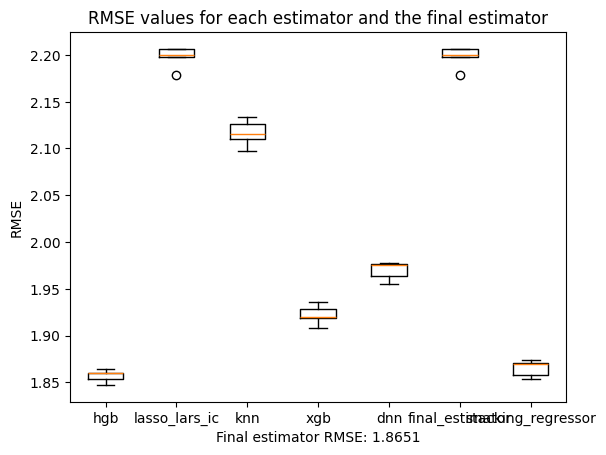

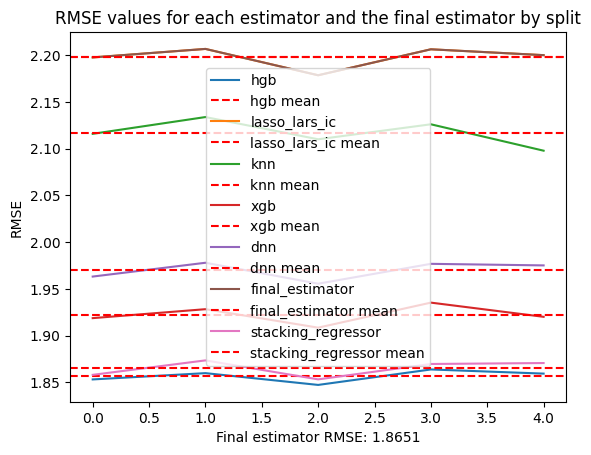

In [8]:
from datetime import datetime
import os
from model_performance_calculations import calculate_stacking_regressor_performance, get_rmse_boxplot_chart, get_rmse_line_chart, save_performances, save_model

date_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_name = f'{date_time}-model-v5.0-all-tuned-base'

save_model(model, os.path.join('models', f'{model_name}.pkl'))

performances = calculate_stacking_regressor_performance(model, X_train, y_train, X_additional_train, y_additional_train, n_splits=5)
save_performances(performances, os.path.join('models', f'{model_name}-performances.json'))

get_rmse_boxplot_chart(performances).show()
get_rmse_line_chart(performances).show()

In [9]:
import numpy as np
from pipelines_selected_features import pipeline

all_train_data_transformed = pipeline.fit_transform(pd.concat([train_data, additional_train_data], axis=0))

X_train = all_train_data_transformed.drop(columns=['bg+1:00'])
y_train = all_train_data_transformed['bg+1:00']
X_test = pipeline.transform(test_data)

model.fit(X_train, y_train)

/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


9987/9987 - 3s - 306us/step - loss: 3.9626 - rmse: 3.8232


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7990/7990 - 3s - 321us/step - loss: 3.8791 - rmse: 3.8862
1998/1998 - 1s - 319us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7990/7990 - 3s - 322us/step - loss: 4.1156 - rmse: 3.8487
1998/1998 - 1s - 318us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7990/7990 - 3s - 326us/step - loss: 3.8881 - rmse: 3.8170
1998/1998 - 1s - 316us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7990/7990 - 3s - 320us/step - loss: 4.0074 - rmse: 3.8015
1998/1998 - 1s - 317us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7990/7990 - 3s - 320us/step - loss: 3.8436 - rmse: 3.7427
1998/1998 - 1s - 398us/step


StackingRegressor(estimators=[('hgb',
                               HistGradientBoostingRegressor(l2_regularization=0.0001,
                                                             max_depth=11,
                                                             max_iter=1500,
                                                             min_samples_leaf=10,
                                                             n_iter_no_change=22,
                                                             random_state=42)),
                              ('lasso_lars_ic',
                               LassoLarsIC(eps=0.03922948513965659,
                                           max_iter=1944,
                                           noise_variance=5.4116687755186035e-05)),
                              ('knn', KNeighborsRegressor(n_neighbors=7)),
                              ('xgb',
                               XGBRegressor(bas...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None, min_child_weight=6,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('dnn',
                               KerasRegressor(model=<function model_with_pretrained_weights at 0x3c2056a20>, verbose=2))],
                  final_estimator=Ridge(alpha=0.1), n_jobs=1, verbose=2)

In [10]:
y_pred = model.predict(X_test)
test_data['bg+1:00'] = y_pred

if np.sum(y_pred < 0) > 0:
    print(f'Number of negative values: {np.sum(y_pred < 0)}')
    bg_min_train = np.min(y_train)
    print(f'Min value: {np.min(y_pred)}')
    print(f'Filling negative values with {bg_min_train}')
    y_pred = np.where(y_pred < 0, bg_min_train, y_pred)

test_data['bg+1:00'] = y_pred
test_data.head()

114/114 - 0s - 1ms/step


,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
id,,,,,,,,,,,,,,,,,,,,,
p01_8459,p01,06:45:00,NaN,9.2,NaN,NaN,10.2,NaN,NaN,10.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.339411
p01_8460,p01,11:25:00,NaN,NaN,9.9,NaN,NaN,9.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Walk,Walk,Walk,6.463608
p01_8461,p01,14:45:00,NaN,5.5,NaN,NaN,5.5,NaN,NaN,5.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.524366
p01_8462,p01,04:30:00,NaN,3.4,NaN,NaN,3.9,NaN,NaN,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.991856
p01_8463,p01,04:20:00,NaN,NaN,8.3,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.085238


In [11]:
submission = pd.DataFrame(test_data['bg+1:00'])
submission

,bg+1:00
id,
p01_8459,8.339411
p01_8460,6.463608
p01_8461,7.524366
p01_8462,11.991856
p01_8463,7.085238
...,...
p24_256,6.287997
p24_257,10.401179
p24_258,6.456077


In [12]:
submission.to_csv(f'submission-{os.path.basename(os.getcwd())}.csv')

NameError: name 'submission' is not defined